In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

This ipython notebook will illustrate the matching methodology we will use to match patients in the SEER-Medicare linked database. The comparison between patient outcomes between those patients who receive proton beam therapy vs traditional radiation therapy requires as a first step a matching of the two different groups. One method to perform this matching is to use Propensity Score Matching. Here we are going to illustrate a more direct method of matching using KDTrees, a data structure that allows for efficient finding of nearest neighbors in high-dimenional space.


We will illustrate the medthodology by using it in the 
latest release of the SEER data. We will take in the colon cancer patient data, and treat the male and female patients as the treatment and control groups, respectively. We will perform the patient matching and show the overall improvement in coviarate balancing that results. We will then ask two questions: "Are Males or Females more likely to be uninsured?" (A discrete outcome; use Bayesian A/B testing), and "Are Male or Female colon cancer patients more likely to live at higher elevation?" (A question involving distributions; answered by sampling repeatedly from the empirical CDFs for both the treatment and control groups).

In [5]:
import seerhelp

colorectfiles = seerhelp.get_colorectfiles()
colorectfiles

['SEER_1973_2013_TEXTDATA\\incidence\\yr1973_2013.seer9\\COLRECT.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr1992_2013.sj_la_rg_ak\\COLRECT.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr2000_2013.ca_ky_lo_nj_ga\\COLRECT.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr2005.lo_2nd_half\\COLRECT.txt']

In [6]:
dfcolon0 = seerhelp.make_clean_dataframe(colorectfiles[0])

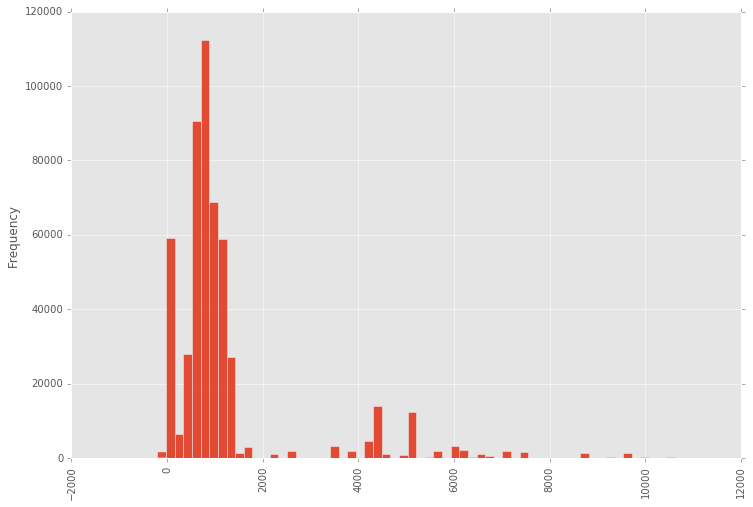

In [8]:
dfcolon0['elevation'].plot(kind='hist',bins=60,rot=90,figsize=((12,8)));

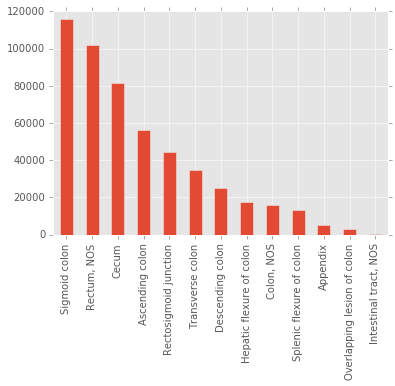

In [11]:
dfcolon0['PRIMSITE'].value_counts().plot(kind='bar',rot=90);


## <font color='purple'>One-Hot Encode the categorical variables we wish to include</font>

In order to find the nearest neighbors in the high-dimensional feature space, we need to first do soem preprocessing of the data. The first step is to "one-hot encode" the categorical features.

In [12]:

mask = (dfcolon0['CSTUMSIZ'] != "Unknown; size not stated; not stated in patient record") & \
 (dfcolon0['CSTUMSIZ'] != "Microscopic focus or foci only; no size of focus is given") & \
 (dfcolon0['CSTUMSIZ'] != "989 millimeters or larger") & \
 (dfcolon0['CSTUMSIZ'] != "Not applicable") & \
 (dfcolon0['AGE_DX'] != "Unknown age") & \
 (dfcolon0['srv_time_mon_flag'] == "Complete dates are available and there are more than 0 days of survival") & \
 (dfcolon0['REC_NO'] == 1) & \
 (dfcolon0['YEAR_DX'] >= 2004) & \
 (dfcolon0['CSTUMSIZ'] != "Described as less than 1 cm") & \
(dfcolon0['CSTUMSIZ'] != "Described as less than 2 cm") & \
(dfcolon0['CSTUMSIZ'] != "Described as less than 3 cm") & \
(dfcolon0['CSTUMSIZ'] != 'Indicates no msas or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized') & \
(dfcolon0['CSTUMSIZ'] != "Described as less than 4 cm") & \
(dfcolon0['CSTUMSIZ'] != "Described as less than 5 cm") & \
(dfcolon0['CSTUMSIZ'] != "Not applicable") & \
(dfcolon0['YR_BRTH'] != 'Unknown year of birth') & \
(dfcolon0['CSTUMSIZ'] != 'Not applicable') & \
(dfcolon0['CSTUMSIZ'] != 996) & \
(dfcolon0['CSTUMSIZ'] != 997) & \
(dfcolon0['CSTUMSIZ'] != 998)

In [13]:
dfsmall = dfcolon0[mask].copy()

In [31]:
dfsmall.set_index('PUBCSNUM',inplace=True)


In [32]:
dfsmall.shape

(74179, 140)

In [33]:
dfsmall.SEX.value_counts()

Male      37606
Female    36573
Name: SEX, dtype: int64

## <font color='purple'>Treatment and Control group definitions</font>

Let's consider ```(dfsmall.SEX == "Male")``` as the **treatment** group and 
```(dfsmall.SEX == "Female")``` as the **control** group. We need to match patients in the tratment group with those in the control group.

In [34]:
catcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC']

goodcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC',
           'YR_BRTH','AGE_DX','YEAR_DX','CSTUMSIZ',
           'lat','lng']


In [35]:
resgood = pd.concat([pd.get_dummies(dfsmall[col],prefix=col) for col in catcols], axis=1)

In [36]:
resgood['YR_BRTH'] = dfsmall['YR_BRTH']
resgood['AGE_DX'] = dfsmall['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgood['YEAR_DX'] = dfsmall['YEAR_DX']
resgood['CSTUMSIZ'] = dfsmall['CSTUMSIZ']
resgood['lat'] = dfsmall['lat']
resgood['lng'] = dfsmall['lng']
resgood['srv_time_mon'] = dfsmall['srv_time_mon']


print(resgood.shape)

(74179, 115)


In [37]:
resgood['STAT_REC_Dead'].value_counts()

0.0    47051
1.0    27128
Name: STAT_REC_Dead, dtype: int64

After performing the matching between the control and treatment groups, we can see how the kaplan-meier curves differ

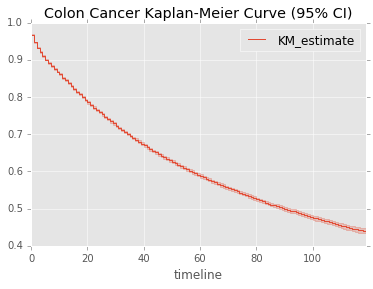

In [38]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

T = resgood["srv_time_mon"]
E = resgood["STAT_REC_Dead"]

kmf.fit(T, event_observed=E);
kmf.plot()
plt.title("Colon Cancer Kaplan-Meier Curve (95% CI)");

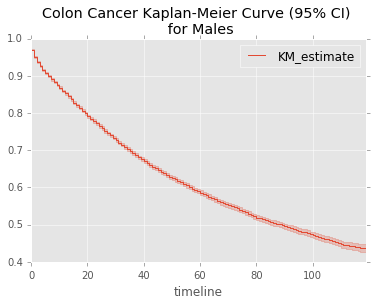

In [39]:
from lifelines import KaplanMeierFitter

kmfmales = KaplanMeierFitter()

T = resgood[resgood.SEX_Male == 1]["srv_time_mon"]
E = resgood[resgood.SEX_Male == 1]["STAT_REC_Dead"]

kmfmales.fit(T, event_observed=E);
kmfmales.plot()
plt.title("Colon Cancer Kaplan-Meier Curve (95% CI) \n for Males");

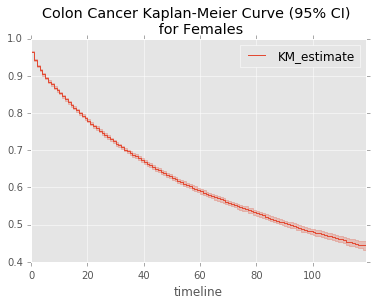

In [40]:
from lifelines import KaplanMeierFitter

kmffemales = KaplanMeierFitter()

T = resgood[resgood.SEX_Male == 0]["srv_time_mon"]
E = resgood[resgood.SEX_Male == 0]["STAT_REC_Dead"]

kmffemales.fit(T, event_observed=E);
kmffemales.plot()
plt.title("Colon Cancer Kaplan-Meier Curve (95% CI) \n for Females");

In [41]:
resgood['YR_BRTH'] = resgood['YR_BRTH'].astype('int')
resgood['AGE_DX'] = resgood['AGE_DX'].astype('int')
resgood['CSTUMSIZ'] = resgood['CSTUMSIZ'].astype('float')
resgood['lat'] = resgood['lat'].astype('float')
resgood['lng'] = resgood['lng'].astype('float')
resgood['srv_time_mon'] = resgood['srv_time_mon'].astype('float')

In [42]:
newcolumns = list(resgood.columns)
list(newcolumns)

['SEX_Female',
 'SEX_Male',
 'MAR_STAT_Divorced',
 'MAR_STAT_Married (including common law)',
 'MAR_STAT_Separated',
 'MAR_STAT_Single (never married)',
 'MAR_STAT_Unknown',
 'MAR_STAT_Unmarried or domestic partner (same sex or opposite sex or unregistered)',
 'MAR_STAT_Widowed',
 'RACEIV_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)',
 'RACEIV_Asian Indian',
 'RACEIV_Asian Indian or Pakistani, NOS',
 'RACEIV_Black',
 'RACEIV_Chamorran',
 'RACEIV_Chinese',
 'RACEIV_Fiji Islander',
 'RACEIV_Filipino',
 'RACEIV_Guamanian, NOS',
 'RACEIV_Hawaiian',
 'RACEIV_Hmong',
 'RACEIV_Japanese',
 'RACEIV_Kampuchean (including Khmer and Cambodian)',
 'RACEIV_Korean',
 'RACEIV_Laotian',
 'RACEIV_Melanesian, NOS',
 'RACEIV_Micronesian, NOS',
 'RACEIV_New Guinean',
 'RACEIV_Other',
 'RACEIV_Other Asian, including Asian, NOS and Oriental NOS',
 'RACEIV_Pacific Islander, NOS',
 'RACEIV_Pakistani',
 'RACEIV_Polynesian, NOS',
 'RACEIV_Samo

In [43]:
newcolumns.remove('srv_time_mon')
newcolumns.remove('STAT_REC_Alive')
newcolumns.remove('STAT_REC_Dead')
newcolumns.remove('SEX_Female')

In [44]:
resgreat = resgood[newcolumns].copy()
resgreat.head()

,SEX_Male,MAR_STAT_Divorced,MAR_STAT_Married (including common law),MAR_STAT_Separated,MAR_STAT_Single (never married),MAR_STAT_Unknown,MAR_STAT_Unmarried or domestic partner (same sex or opposite sex or unregistered),MAR_STAT_Widowed,"RACEIV_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)",RACEIV_Asian Indian,...,MDXRECMP_May,MDXRECMP_Nov,MDXRECMP_Oct,MDXRECMP_Sep,YR_BRTH,AGE_DX,YEAR_DX,CSTUMSIZ,lat,lng
PUBCSNUM,,,,,,,,,,,,,,,,,,,,,
7000298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1926,86,2012,8.0,41.326691,-72.804280
7000375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1918,88,2006,75.0,41.518519,-72.046816
7000588,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1921,83,2004,55.0,41.469851,-72.473153
7000592,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1927,83,2010,40.0,41.792434,-72.804280
7000642,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1943,67,2011,45.0,41.792434,-72.804280


In [45]:
resgreat['League'] = resgreat['SEX_Male']
resgreat.head()

,SEX_Male,MAR_STAT_Divorced,MAR_STAT_Married (including common law),MAR_STAT_Separated,MAR_STAT_Single (never married),MAR_STAT_Unknown,MAR_STAT_Unmarried or domestic partner (same sex or opposite sex or unregistered),MAR_STAT_Widowed,"RACEIV_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)",RACEIV_Asian Indian,...,MDXRECMP_Nov,MDXRECMP_Oct,MDXRECMP_Sep,YR_BRTH,AGE_DX,YEAR_DX,CSTUMSIZ,lat,lng,League
PUBCSNUM,,,,,,,,,,,,,,,,,,,,,
7000298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1926,86,2012,8.0,41.326691,-72.804280,0.0
7000375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1918,88,2006,75.0,41.518519,-72.046816,0.0
7000588,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1921,83,2004,55.0,41.469851,-72.473153,1.0
7000592,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1927,83,2010,40.0,41.792434,-72.804280,0.0
7000642,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1943,67,2011,45.0,41.792434,-72.804280,0.0


In [46]:
del resgreat['SEX_Male']
resgreat.head()

,MAR_STAT_Divorced,MAR_STAT_Married (including common law),MAR_STAT_Separated,MAR_STAT_Single (never married),MAR_STAT_Unknown,MAR_STAT_Unmarried or domestic partner (same sex or opposite sex or unregistered),MAR_STAT_Widowed,"RACEIV_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)",RACEIV_Asian Indian,"RACEIV_Asian Indian or Pakistani, NOS",...,MDXRECMP_Nov,MDXRECMP_Oct,MDXRECMP_Sep,YR_BRTH,AGE_DX,YEAR_DX,CSTUMSIZ,lat,lng,League
PUBCSNUM,,,,,,,,,,,,,,,,,,,,,
7000298,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1926,86,2012,8.0,41.326691,-72.804280,0.0
7000375,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1918,88,2006,75.0,41.518519,-72.046816,0.0
7000588,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1921,83,2004,55.0,41.469851,-72.473153,1.0
7000592,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1927,83,2010,40.0,41.792434,-72.804280,0.0
7000642,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1943,67,2011,45.0,41.792434,-72.804280,0.0


In [47]:
dftree = resgreat.copy()
dftree.columns


Index(['MAR_STAT_Divorced', 'MAR_STAT_Married (including common law)',
       'MAR_STAT_Separated', 'MAR_STAT_Single (never married)',
       'MAR_STAT_Unknown',
       'MAR_STAT_Unmarried or domestic partner (same sex or opposite sex or unregistered)',
       'MAR_STAT_Widowed',
       'RACEIV_American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)',
       'RACEIV_Asian Indian', 'RACEIV_Asian Indian or Pakistani, NOS',
       ...
       'MDXRECMP_Nov', 'MDXRECMP_Oct', 'MDXRECMP_Sep', 'YR_BRTH', 'AGE_DX',
       'YEAR_DX', 'CSTUMSIZ', 'lat', 'lng', 'League'],
      dtype='object', length=111)

In [48]:
y = dftree['League'].copy()
del dftree['League']

In [49]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plot
#import psycopg2
import random
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cross_validation import StratifiedShuffleSplit
import pylab as plot
from pandas import DataFrame, Series
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn import feature_extraction
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
#from sklearn.neural_network import MultilayerPerceptronClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.svm import SVC
import pylab as pl
from sklearn.decomposition import RandomizedPCA
from itertools import cycle
from sklearn.cross_validation import ShuffleSplit
from scipy.stats import sem
from pprint import pprint
from math import sqrt, fabs, exp
import matplotlib.pyplot as plot
from sklearn.cross_validation import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, roc_curve
import numpy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from pandas.tools.plotting import lag_plot

This brute=force method of finding similar matches in this high-dimensional space is possible for this data set as well as for Big Data sized data sets thanks to a data structure called a KDTree. We need to first transform the numeric data so that all of the different features contribute equally to the euclidean distance between records.

For example, **AGE_DX** is on the order of 60 or so, while **YR_BRTH** is around 1960. Without standardization, **YR_BRTH** would contribute much more heavily to the distance between teams than **AGE_DX**. The result of standardization (or Z-score normalization) is that the features will be rescaled so that they will have the properties of a standard normal distribution with

$
\mu = 0 \mbox{ and } \sigma = 1
$

where $\mu$ is the mean (average) and $\sigma$ is the standard deviation from the mean; standard deviation scores (also called $z$ scores are then calculated as follows:

$
z = \frac{x - \mu}{\sigma}
$